<img src="https://3a2vzv37nkuw3esf6a3u2t7s-wpengine.netdna-ssl.com/webcentral/wp-content/uploads/sites/267/2019/02/horizontaldarkbackground.jpg" width="55%" align="left"> 
<br><br><br><br><br>
<font size=3 color='#08088A'>
<b>CSCI250 Python Computing: Building a Sensor System</b> <br><br>
Capstone Final Report
</font>
<hr style="height:5px" width="55%" align="left">

# SheeshOMeter with Machine Learning
Video: https://youtu.be/BPozN8fCfOA


# Group - The A Team:

* James Shima, Machine Learning
* Ryan McDermot, Hardware
* Jamie Slick, Software and Supplies
* David Nguyen, Software and Testing

# Description

The SheeshOMeter is a device that measures the arm angle and voice of its user and then uses Machine Learning to tell whether or not the user said "Sheeesh". This device was inspired by a common phrase that is hip and cool with the youth.
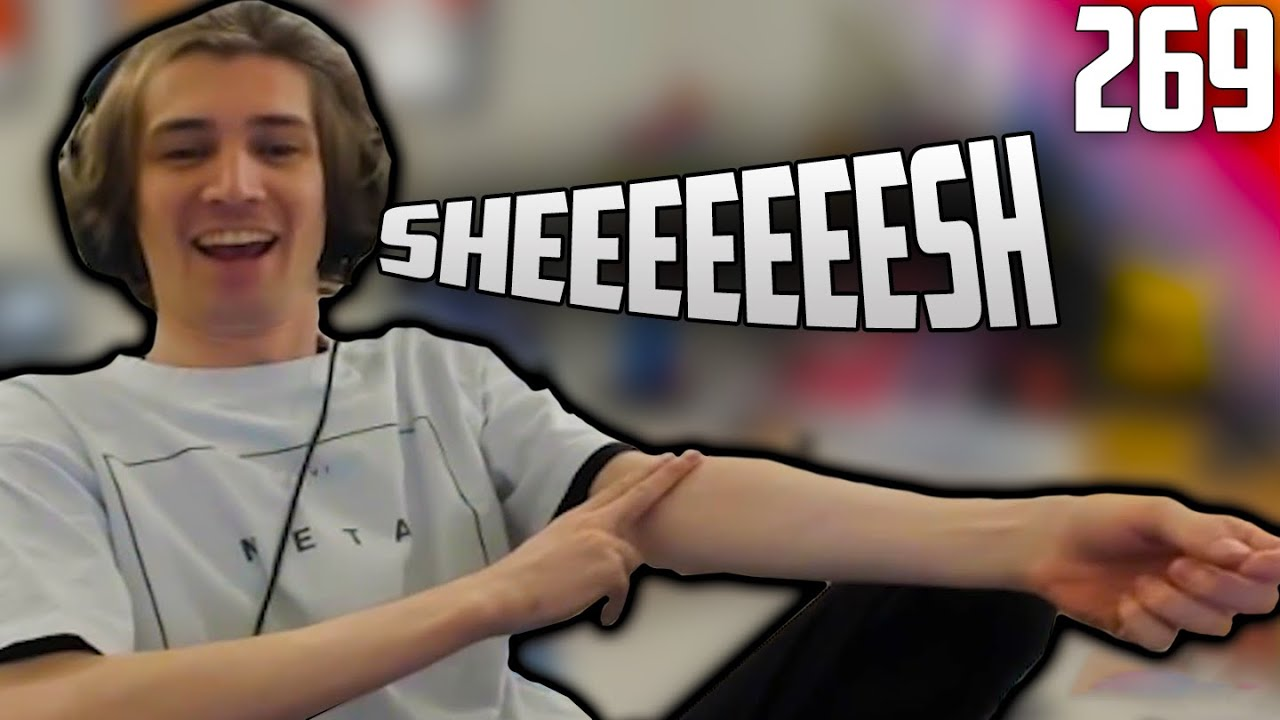

# Hardware

* Piezo Element - starts recording data.
* Microphone - captures audio data later used as a spectrogram for machine learning
* Accelorometer - meassures the users arm angle


# Operation

The device is straped to the user's arm and starts recording the user's voice and arm angle after they hit the piezo element for two seconds.

# Data

As stated in the capstone guidelines notebook, your project must have 4 data components:

1. **Collect** We used a data set of about 200 spectrograms recorded by our device of saying sheesh and other phrases.
2. **Process** The data originally in the form of a np.array is cleaned then ploted as a spectrogram and saved as a .jpg for our data set. 
3. **Display** Our display is simply a shell output saying whether or not our audio was a sheesh or not as well as the audio data, arm angle data, and respective graphs.
4. **Interpret** Data is fed through a Sequential Neural Network using tensorflow and predicts if the output from the pi was a Sheesh or Not a Sheesh.

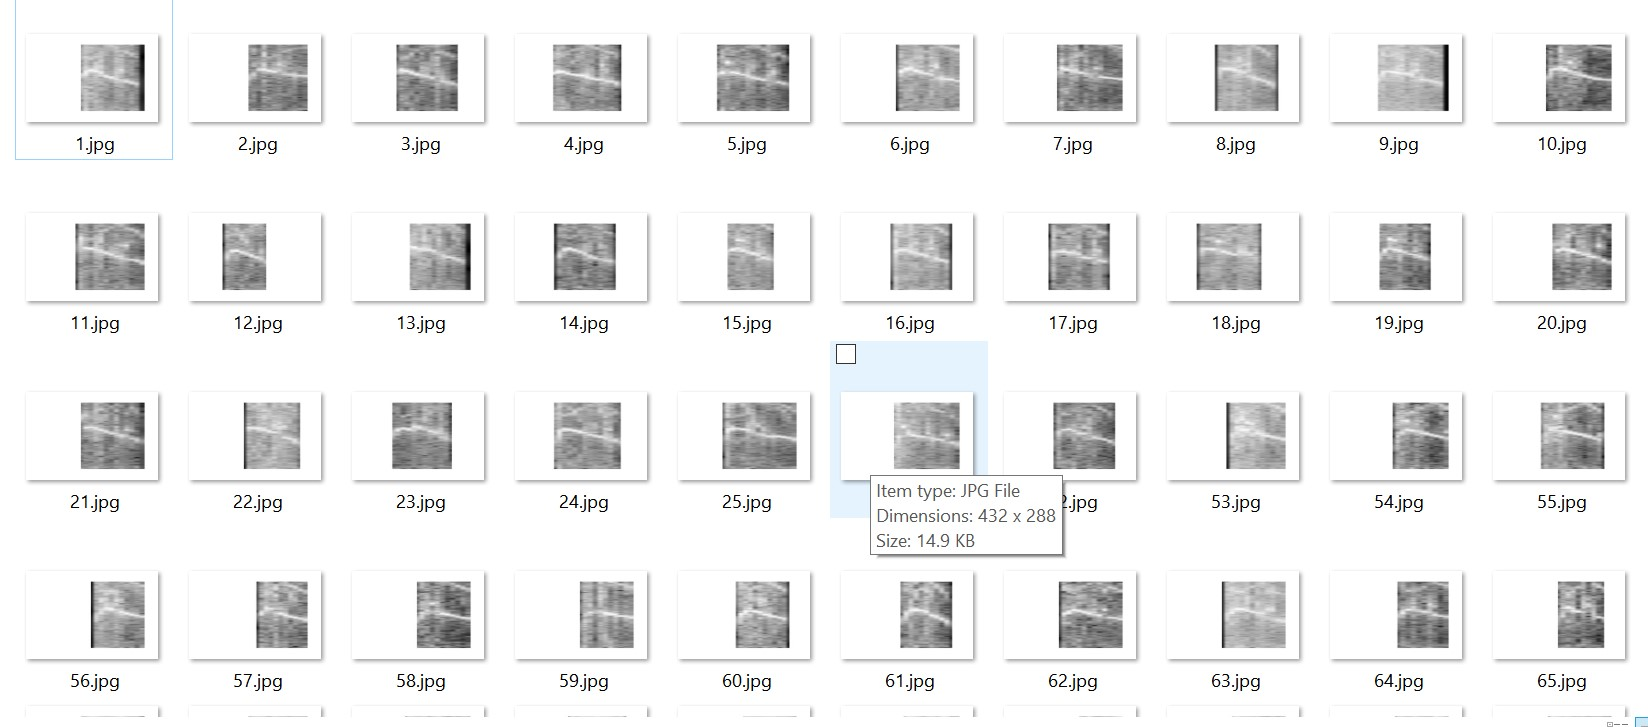

# Wiring

* Each of our device elements are straped to a wristband that goes on the user's arm extending down to the board.  On the board we have 2 ADC chips, one for the piezo element and one for the microphone.  The other wiring is using just GPIO pins and follwing the wiring given in the class notebooks.
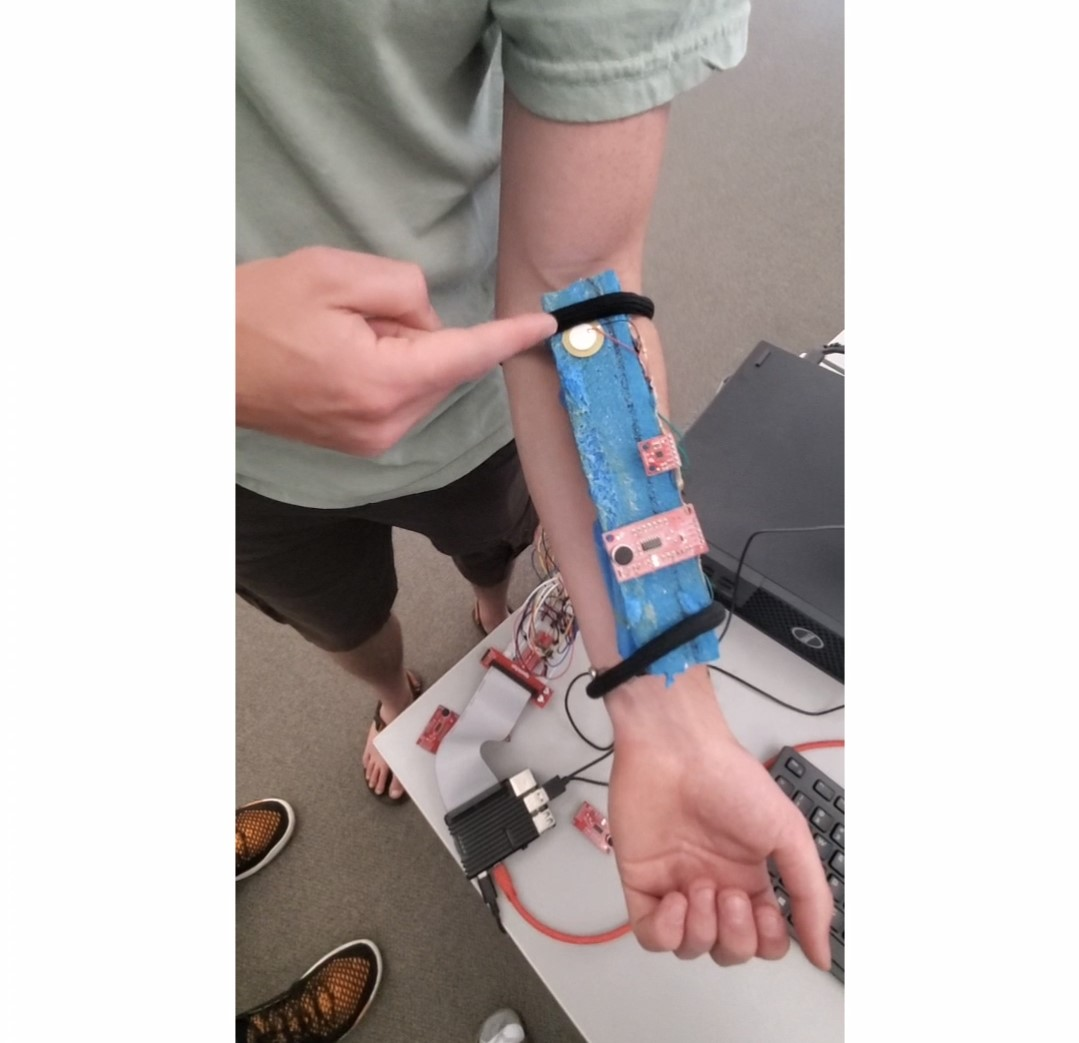

# Code

In [ ]:
#SheeshOMeter Hardware Code:
import accUtil as acc
import adcUtil as adc
import math
import RPi.GPIO as GPIO
import numpy as np
import time
import matplotlib.pyplot as plt

# vars:
GPIO.setmode(GPIO.BCM)
gatePin = 18
GPIO.setup(gatePin, GPIO.IN)
dPIEZO = 0
flag = 0
envl = np.empty(0)
timeArray = np.empty(0)
gateArray = np.empty(0)
counter = 0
angle = 0  

# wait for peizo element:
while(True):
    piezo = adc.readADC(channel=0, device=0)
    
    # on hit:
    if(piezo > 0.2):
        time.sleep(0.5)
        ax,ay,az = acc.readACC()
        #find angle:
        angle = math.atan(ay/az) *(180/math.pi) * -1
        timeStart = time.time()
        t0 = timeStart
        # record audio for 2 secs:
        while (t0 < timeStart + 2):
            envl = np.append(envl,  adc.readADC(channel=1,device=0))
            gateState = GPIO.input(gatePin)
            gateArray = np.append(gateArray, gateState)
            timeArray = np.append(timeArray, t0 - timeStart)
            counter += 1
            t0 = time.time()
        
        break

# clean audio data:
audio = envl
mean = np.mean(audio)
audio -= mean
for i in range(len(gateArray)):
    if gateArray[i] == 0:
        audio[i] = 0

# logic:
envl = envl - 1.6
envl = np.absolute(envl)
thresholdOver = 0
counterStart = 0
continous = False
doneRecording = False

for i in range(len(envl)):
    if envl[i] > 0.4 and continuous:
        counterStart = i
        thresholdOver += 1
    if envl[i] > 0.4:
        continuous = True
        doneRecording = True
    else:
        continuous = False
        if doneRecording: 
            doneRecording = False 
        
# angle processing:
if (thresholdOver > 30 and angle > 30 and angle < 60):
    print("Perfect Sheesh")
elif (thresholdOver < 30):
    print("Bad Sheesh; Arm too low")
elif (thresholdOver > 60):
    print("Bad Sheesh; Arm too high")

    
# graphing/output:
print("Over: ",thresholdOver)
print("Counter Start: ",counterStart)
print(envl)
plt.plot(timeArray,envl,"b")
plt.show()
plt.specgram(audio, Fs=8,cmap="gray")
plt.axis('off')
plt.savefig("test.jpg", transparent=True)
plt.show()

In [ ]:
#Machine Learning w/ tensorflow NOT TRAINED ON THE PI:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

DATADIR = "C://Users//James//Documents//CSCI250//Datasets//SheeshSpectroImgs"
Categories = ["Sheesh","Not a Sheesh"]

# test images are loaded correctly:
for category in Categories:
    path = os.path.join(DATADIR,category) # path to dir:
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap="gray")
plt.show()  



training_data = []

def create_data():
    for category in Categories:
        path = os.path.join(DATADIR,category) # path to dir:
        class_num = Categories.index(category) 
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass

            
create_data()

print(len(training_data))

import random as rand

rand.shuffle(training_data)

X = [] #data
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE,IMG_SIZE, 1)
y = np.array(y)


X = X/255.0

# network:
model = Sequential()

model.add(Conv2D(64,(3,3),input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X,y,batch_size=1, epochs=10, validation_split=0.1)


model.save('sheeshML.h5')

new_model = tf.keras.models.load_model('sheesh.model')

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE, IMG_SIZE, 1)

#prediction:
prediction = new_model.predict([prepare("C://Users//James//Downloads//test.jpg")])
print("That was a",Categories[int(prediction[0][0])])

# Credits
* tensorflow 2.4.0 - https://www.tensorflow.org/install/
* cv2 - pip3 install opencv-python
* StackOverflow (for synataxs) - https://stackoverflow.com/
* keras API for tensorflow - https://keras.io/
* numpy - pip3 install numpy
* matplotlib - pip3 install matplotlib
* Libraries from class